In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 w

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import DistilBertTokenizer
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from transformers import ViTModel, DistilBertModel
import matplotlib.pyplot as plt
import textwrap
from torch import optim

In [4]:
from datasets import load_dataset
ds = load_dataset("wangherr/coco2017_caption_depth", split="train[:10000]")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/372 [00:00<?, ?B/s]

train-00000-of-00013.parquet:   0%|          | 0.00/461M [00:00<?, ?B/s]

train-00001-of-00013.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

train-00002-of-00013.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

train-00003-of-00013.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

train-00004-of-00013.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

train-00005-of-00013.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

train-00006-of-00013.parquet:   0%|          | 0.00/460M [00:00<?, ?B/s]

train-00007-of-00013.parquet:   0%|          | 0.00/461M [00:00<?, ?B/s]

train-00008-of-00013.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

train-00009-of-00013.parquet:   0%|          | 0.00/461M [00:00<?, ?B/s]

train-00010-of-00013.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

train-00011-of-00013.parquet:   0%|          | 0.00/459M [00:00<?, ?B/s]

train-00012-of-00013.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/118287 [00:00<?, ? examples/s]

In [5]:
sample = ds[0]
print(sample)

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7EF73C0D9390>, 'text': 'Closeup of bins of food that include broccoli and bread.', 'conditioning_image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7EF73C0F2A90>}


In [6]:
len(ds)

10000

In [7]:
class CLIP_Dataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        image = self.transform(item['image'])

        text = item['text']
        inputs = self.tokenizer(text, padding='max_length', truncation=True, return_tensors="pt")

        return {
            "image": image,
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0)
        }

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

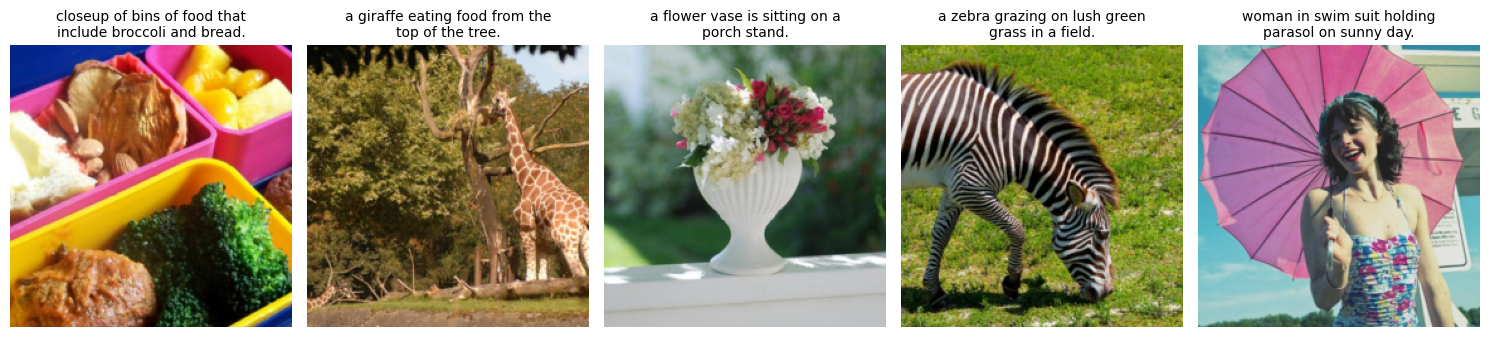

In [8]:
clip_dataset = CLIP_Dataset(ds)

def visualize_samples(dataset, tokenizer, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i in range(num_samples):
        item = dataset[i]
        image, input_ids = item['image'], item['input_ids']

        text = tokenizer.decode(input_ids, skip_special_tokens=True)

        wrapped_text = "\n".join(textwrap.wrap(text, width=30))

        image = image.permute(1, 2, 0).numpy()

        ax = axes[i]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(wrapped_text, fontsize=10)

    plt.tight_layout()
    plt.show()

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

visualize_samples(clip_dataset, tokenizer, num_samples=5)

In [9]:
class TextEncoder(nn.Module):
    def __init__(self, embed_dim, proj_dim):
        super().__init__()
        self.model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.projection = nn.Linear(embed_dim, proj_dim)
        self.layer_norm = nn.LayerNorm(proj_dim)

    def forward(self, input_ids, attention_mask):
        x = self.model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x = x[:, 0, :]
        x = self.projection(x)
        return self.layer_norm(x)

In [10]:
class ImageEncoder(nn.Module):
    def __init__(self, proj_dim):
        super().__init__()
        self.model = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.projection = nn.Linear(self.model.config.hidden_size, proj_dim)
        self.layer_norm = nn.LayerNorm(proj_dim)

    def forward(self, x):
        x = self.model(pixel_values=x).last_hidden_state[:, 0, :]
        x = self.projection(x)
        return self.layer_norm(x)

In [11]:
class CLIPModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.image_encoder = ImageEncoder(proj_dim=256).to(self.device)
        self.text_encoder = TextEncoder(embed_dim=768, proj_dim=256).to(self.device)
        self.temperature = nn.Parameter(torch.ones([]) * torch.log(torch.tensor(1/7.0))).to(self.device)

    def forward(self, x):
        I_t = self.image_encoder(x["image"])
        T_t = self.text_encoder(x["input_ids"], x["attention_mask"])
        logits = I_t @ T_t.T * torch.exp(self.temperature)
        labels = torch.arange(I_t.size(0)).to(self.device)
        loss_I = F.cross_entropy(logits.T, labels)
        loss_T = F.cross_entropy(logits, labels)
        loss = (loss_I + loss_T) / 2.0
        return loss, logits

In [ ]:
train_size = int(0.8 * len(clip_dataset))
val_size = len(clip_dataset) - train_size
train_dataset, val_dataset = random_split(clip_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CLIPModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for param in model.image_encoder.model.parameters():
    param.requires_grad = True

for param in model.text_encoder.model.parameters():
    param.requires_grad = True

def calculate_accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    return correct / labels.size(0)

epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in train_loader:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        loss, logits = model(batch)
        loss.backward()
        optimizer.step()

        labels = torch.arange(logits.size(0)).to(device)
        batch_accuracy = calculate_accuracy(logits, labels)
        total_correct += batch_accuracy * logits.size(0)
        total_samples += logits.size(0)

        total_loss += loss.item()

    train_accuracy = total_correct / total_samples

    model.eval()
    val_loss = 0
    val_correct = 0
    val_samples = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            loss, logits = model(batch)
            labels = torch.arange(logits.size(0)).to(device)
            val_accuracy = calculate_accuracy(logits, labels)

            val_correct += val_accuracy * logits.size(0)
            val_samples += logits.size(0)

            val_loss += loss.item()

    val_accuracy = val_correct / val_samples

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {total_loss/len(train_loader):.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1/5, Training Loss: 0.8084, Training Accuracy: 0.7436, Validation Loss: 0.4808, Validation Accuracy: 0.8360
Epoch 2/5, Training Loss: 0.3029, Training Accuracy: 0.8838, Validation Loss: 0.4549, Validation Accuracy: 0.8465
Epoch 3/5, Training Loss: 0.2240, Training Accuracy: 0.9131, Validation Loss: 0.4309, Validation Accuracy: 0.8550
Epoch 4/5, Training Loss: 0.2063, Training Accuracy: 0.9203, Validation Loss: 0.4688, Validation Accuracy: 0.8515
Epoch 5/5, Training Loss: 0.1809, Training Accuracy: 0.9303, Validation Loss: 0.5178, Validation Accuracy: 0.8375


In [ ]:
torch.save(model.state_dict(), "model_clip.pth")

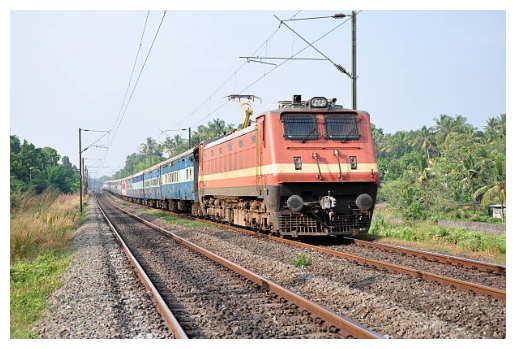

Predicted Label: a train on a track


In [ ]:
image_path = "/content/istockphoto-466506979-612x612.jpg"
image = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

image_tensor = transform(image).unsqueeze(0).to(device)

texts = [
    "a dog playing in the park",
    "a train on a track",
    "a person riding a skateboard",
    "a close-up of a flower in bloom"
]

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
text_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)

with torch.no_grad():
    text_embeddings = model.text_encoder(text_inputs["input_ids"], text_inputs["attention_mask"])

with torch.no_grad():
    image_embeddings = model.image_encoder(image_tensor)

similarity_scores = F.cosine_similarity(image_embeddings.unsqueeze(1), text_embeddings.unsqueeze(0), dim=-1)

predicted_index = torch.argmax(similarity_scores, dim=1).item()

predicted_label = texts[predicted_index]

plt.imshow(image)
plt.axis('off')
plt.show()

print(f"Predicted Label: {predicted_label}")

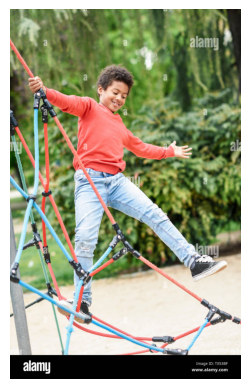

Predicted Label: a kid playing in the park


In [31]:
image_path = "/content/little-boy-playing-on-playground-in-a-park-climbing-in-a-jungle-gym-TX53BF.jpg"
image = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

image_tensor = transform(image).unsqueeze(0).to(device)

texts = [
    "a dog eating food",
    "a train on a track",
    "a kid playing in the park",
    "a close-up of a flower in bloom"
]

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
text_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)

with torch.no_grad():
    text_embeddings = model.text_encoder(text_inputs["input_ids"], text_inputs["attention_mask"])

with torch.no_grad():
    image_embeddings = model.image_encoder(image_tensor)

similarity_scores = F.cosine_similarity(image_embeddings.unsqueeze(1), text_embeddings.unsqueeze(0), dim=-1)

predicted_index = torch.argmax(similarity_scores, dim=1).item()

predicted_label = texts[predicted_index]

plt.imshow(image)
plt.axis('off')
plt.show()

print(f"Predicted Label: {predicted_label}")